In [1]:
import numpy as np
import json
from scipy import optimize
from os import listdir
import re
import os
from os.path import isfile, join

import pandas as pd
from joblib import Parallel, delayed, dump
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import measure
import matplotlib
import seaborn as sns
import csv
from scipy.stats import stats

In [2]:
NJOBS = 35

In [3]:
#sns.set(style="white")
#sns.set_context("paper")

def figsize(scale,ratio):
    fig_width_pt = 468.0                      # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    if(ratio == "golden"):                          # Golden ratio ...
        fig_height = fig_width*golden_mean          # height in inches
    else:                                           # ... or other ratio
        fig_height = fig_width*ratio
        
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {'backend': 'pdf',
                                            'axes.labelsize': 8,
                                            'xtick.labelsize': 8,
                                            'ytick.labelsize': 8,
                                            'legend.fontsize': 8,
                                            'lines.markersize': 3,
                                            'font.size': 8,
                                            'font.family': u'sans-serif',
                                            'font.sans-serif': ['Arial'],
                                            'pdf.fonttype': 42,
                                              'ps.fonttype': 42,
                                            'text.usetex': False}
matplotlib.rcParams.update(pgf_with_latex)

In [4]:
from collections import defaultdict
import gzip
from tqdm import tqdm_notebook
from itertools import chain

def collect_distance_file(prefix, directoryname, tileid):
    with gzip.open(directoryname + '{}{}.json.gz'.format(prefix, tileid), 'rt') as f:
        d = json.load(f)
    return d['distances'][0]

def collect_distances(directoryname, df_classes, distance_name='energy', modelname=''):
    dours = {}
    drybski = {}
    prefix_name = '{}_'.format(distance_name)
    if modelname:
        prefix_name = '{}_{}_'.format(distance_name, modelname)
        
    prefix_name_rybski = '{}_{}_'.format(distance_name, 'rybski')
      
    for c in [1,2,3,4]:
        tiles = df_classes[df_classes['class'] == c]['tileid'].values
        dours[c] = [r for r in Parallel(n_jobs=NJOBS)(delayed(collect_distance_file)(prefix_name, directoryname, t) for t in tqdm_notebook(tiles)  if isfile(directoryname + '{}{}.json.gz'.format(prefix_name, t)))]
        
        drybski[c] = [r for r in Parallel(n_jobs=NJOBS)(delayed(collect_distance_file)(prefix_name_rybski, directoryname, t) for t in tqdm_notebook(tiles) if isfile(directoryname + '{}{}.json.gz'.format(prefix_name, t)))]
        
    return dours, drybski


def create_dataframe_distances(dours, drybski):
    data = [[ 10, 'tom', 'c']]
    df = pd.DataFrame(data, columns = ['dist', 'Class', 'model']) 

    for c in [1,2,3,4]:
        array_distances = np.hstack((np.array(dours[c]), np.array(drybski[c]))).reshape(-1, 1)


        repeated = np.repeat(c, len(array_distances)).reshape(-1, 1)
        repeated_model = np.hstack((np.repeat('multi', len(dours[c])), np.repeat('rybski', len(dours[c])))).reshape(-1, 1)

        df = pd.concat((df, pd.DataFrame(np.hstack((array_distances, repeated, repeated_model)), columns = ['dist', 'Class', 'model']) ))

    df = df[df['Class']  != 'tom']
    df['dist'] = df['dist'].astype('float32')
    df = df.sort_values(['model', 'Class'])
    return df

def compute_kolmogorov_classes(df):
    for c in ['1', '2', '3', '4']:
        data1 = df[(df['Class'] == c) & (df['model'] == 'multi')]['dist'].values
        data2 = df[(df['Class'] == c) & (df['model'] == 'rybski')]['dist'].values
        d, p = stats.ks_2samp(data1, data2)
        print("KL class {}: {} (p-value {})".format(c, d, p))
    

In [5]:
df_classes = pd.read_csv('../data/generated_files/quantiles_classes.csv', dtype={'tileid': str})
df_classes.head()

,tileid,class,quantile
0,46588,2,0.307
1,47297,3,0.544
2,48000,2,0.428
3,48003,3,0.811
4,48004,2,0.353


In [6]:
df = pd.read_csv('../data/generated_files/summary_tiles_05x05.csv', dtype={'tileid': 'str'})
df['perc_urban'] = df['urban_area_km2'] / df['original_km2']
df['perc_constraint'] = 1 - (df['tile_km2'] / df['original_km2'])

In [7]:
df = pd.merge(df[['tileid', 'perc_urban', 'perc_constraint']], df_classes, on='tileid')

In [8]:
rootdir = "../data/generated_files/simulations/distances/"

dours, drybski = collect_distances(rootdir, df_classes, distance_name='energy')

In [9]:
df = create_dataframe_distances(dours, drybski)
df.head()

,dist,Class,model
0,0.297294,1,multi
1,0.525910,1,multi
2,0.301655,1,multi
3,0.363942,1,multi
4,0.266740,1,multi


In [10]:
print("Model multi")
data1 = df[(df['model'] == 'multi')]['dist'].values
data2 = df[(df['model'] == 'rybski')]['dist'].values
d, p = stats.ks_2samp(data1, data2)
print("KL all: {} (p-value {})".format(d, p))

Model multi
KL all: 0.46788990825688076 (p-value 0.0)


In [11]:
compute_kolmogorov_classes(df)

KL class 1: 0.42851153039832285 (p-value 7.160703539868296e-197)
KL class 2: 0.5511540860885838 (p-value 0.0)
KL class 3: 0.6318883174136665 (p-value 2.954113904612405e-255)
KL class 4: 0.6440080563947633 (p-value 0.0)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Median diff: 61.968034505844116


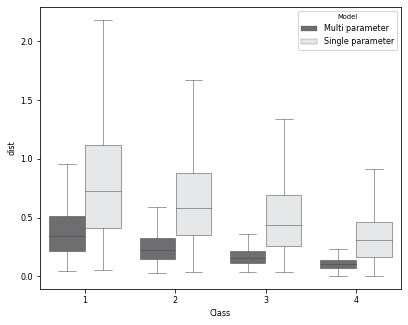

In [12]:
colors = np.array([[109, 110, 113],
                   [230, 231, 232]])/255

f, axs = plt.subplots(1,1, figsize=figsize(1, 0.8))
g = sns.boxplot(x="Class", y="dist", hue='model', data=df, linewidth=0.5, showfliers=False,
           palette=sns.color_palette(colors))

leg = g.axes.get_legend()
leg.set_title('Model')
renames = {'multi': 'Multi parameter', 'rybski': 'Single parameter'}
for t in leg.texts: 
    old = t.get_text()
    t.set_text(renames[old])
    
    
original = np.median(df[df['model'] == 'rybski']['dist'].values)
decrease = original - np.median(df[df['model'] == 'multi']['dist'].values)

print("Median diff:", decrease/original*100)

plt.savefig('../figures/manuscript/boxplot_distances.pdf', dpi=150, bbox_inches='tight', pad_inches=0.05)

In [13]:
doursKL, drybskiKL = collect_distances(rootdir, df_classes, distance_name='kl')
dfKL = create_dataframe_distances(doursKL, drybskiKL)
dfKL.head()

,dist,Class,model
0,0.618191,1,multi
1,0.565136,1,multi
2,0.656640,1,multi
3,0.563968,1,multi
4,0.449171,1,multi


In [14]:
doursJS, drybskiJS = collect_distances(rootdir, df_classes, distance_name='js')
dfJS = create_dataframe_distances(doursJS, drybskiJS)
dfJS.head()

,dist,Class,model
0,0.037751,1,multi
1,0.050295,1,multi
2,0.035134,1,multi
3,0.028619,1,multi
4,0.033513,1,multi


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


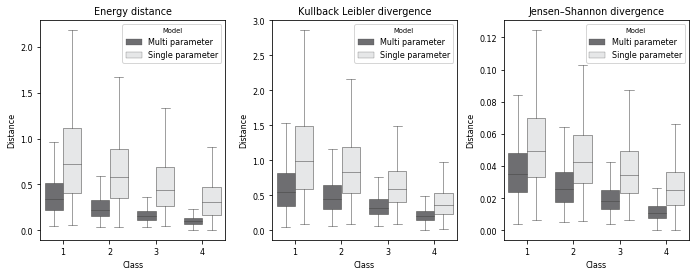

In [15]:
def edit_distance_legend(g):
    leg = g.axes.get_legend()
    leg.set_title('Model')
    renames = {'multi': 'Multi parameter', 'rybski': 'Single parameter'}
    for t in leg.texts: 
        old = t.get_text()
        t.set_text(renames[old])

colors = np.array([[109, 110, 113],
                   [230, 231, 232]])/255

f, axs = plt.subplots(1,3, figsize=figsize(1.5, 0.4))
g = sns.boxplot(x="Class", y="dist", hue='model', data=df, linewidth=0.5, showfliers=False,
           palette=sns.color_palette(colors), ax=axs[0])
edit_distance_legend(g)
    
g = sns.boxplot(x="Class", y="dist", hue='model', data=dfKL, linewidth=0.5, showfliers=False,
           palette=sns.color_palette(colors), ax=axs[1])
edit_distance_legend(g)

g = sns.boxplot(x="Class", y="dist", hue='model', data=dfJS, linewidth=0.5, showfliers=False,
           palette=sns.color_palette(colors), ax=axs[2])
edit_distance_legend(g)

#axs[0].set_ylim((0.2, 2.2))

axs[0].set_ylabel("Distance")
axs[1].set_ylabel("Distance")
axs[2].set_ylabel("Distance")

axs[0].set_title("Energy distance")
axs[1].set_title("Kullback Leibler divergence")
axs[2].set_title("Jensen–Shannon divergence")

f.tight_layout()
plt.savefig('../figures/manuscript/appendix_boxplot_distances.pdf', dpi=150, bbox_inches='tight', pad_inches=0.05)

In [16]:
dmultiprob, drybski = collect_distances(rootdir, df_classes, distance_name='energy', modelname='multi')

In [17]:
df_multiprob = create_dataframe_distances(dmultiprob, drybski)
df_multiprob.head()

,dist,Class,model
0,0.258569,1,multi
1,0.351845,1,multi
2,0.330056,1,multi
3,0.220376,1,multi
4,0.250062,1,multi


In [18]:
print("Model multiprob")
data1 = df_multiprob[(df_multiprob['model'] == 'multi')]['dist'].values
data2 = df_multiprob[(df_multiprob['model'] == 'rybski')]['dist'].values
d, p = stats.ks_2samp(data1, data2)
print("KL all: {} (p-value {})".format(d, p))

Model multiprob
KL all: 0.5350190199149698 (p-value 0.0)


In [19]:
compute_kolmogorov_classes(df_multiprob)

KL class 1: 0.5014675052410902 (p-value 5.04434886245403e-273)
KL class 2: 0.6253898939488459 (p-value 0.0)
KL class 3: 0.6612784717119765 (p-value 5.597122133673865e-282)
KL class 4: 0.6560926485397784 (p-value 0.0)


## Classes real vs simulated

In [21]:
df_classes = pd.read_csv('../data/generated_files/quantiles_classes.csv', dtype={'tileid': str})
print(len(df_classes))
df_classes.head()

44240


,tileid,class,quantile
0,46588,2,0.307
1,47297,3,0.544
2,48000,2,0.428
3,48003,3,0.811
4,48004,2,0.353


In [22]:
from functools import reduce

dfs = []
for m in ['1000', 'rybski', 'marco']:#
    df_temp = pd.read_csv('../data/generated_files/quantiles_classes_{}_all.csv'.format(m), dtype={'tileid': 'str'})
    df_temp = df_temp.rename(columns={'class': 'class_{}'.format(m), 'quantile': 'quantile_{}'.format(m)})
    df_temp['class_{}'.format(m)] = df_temp['class_{}'.format(m)].astype('int')
    dfs.append(df_temp)
    
df_merged_classes = reduce(lambda left,right: pd.merge(left,right, on='tileid'), dfs)
df_merged_classes = pd.merge(df_merged_classes, df_classes.rename(columns={'class': 'class_truth', 'quantile': 'quantile_truth'}), on='tileid')
print(len(df_merged_classes))
df_merged_classes.head()

8938


,tileid,class_1000,quantile_1000,class_rybski,quantile_rybski,class_marco,quantile_marco,class_truth,quantile_truth
0,50123,2,0.180,2,0.173,2,0.209,2,0.126
1,52250,2,0.153,2,0.199,2,0.196,2,0.166
2,60513,2,0.219,2,0.343,2,0.303,2,0.247
3,60749,2,0.285,2,0.143,2,0.189,2,0.166
4,61225,2,0.104,1,0.087,2,0.109,1,0.079


In [23]:
df_merged_classes.to_csv('../data/generated_files/quantiles_classes_merged_all.csv', index=False)

In [24]:
df_melted_classes = df_merged_classes.melt(id_vars=['tileid'], value_vars=['class_1000', 'class_rybski', 'class_truth'], #, 'class_marco'
                      var_name='model', value_name='class')
df_melted_classes.loc[:, 'model'] = df_melted_classes['model'].str.replace('class_', '')
df_melted_classes.head()

,tileid,model,class
0,50123,1000,2
1,52250,1000,2
2,60513,1000,2
3,60749,1000,2
4,61225,1000,2


In [25]:
df_count_classes = df_melted_classes.groupby(['model', 'class'], as_index=False).count()
df_count_classes = df_count_classes.rename(columns={'tileid': 'num'})
df_count_classes.head()

,model,class,num
0,1000,1,2633
1,1000,2,3490
2,1000,3,1274
3,1000,4,1541
4,rybski,1,5873


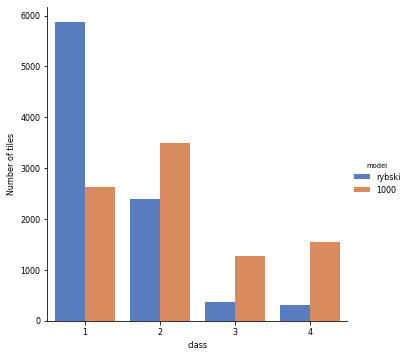

In [26]:
from  matplotlib.ticker import PercentFormatter

g = sns.catplot(x="class", y='num', hue="model", 
                data=df_count_classes[df_count_classes.model.isin({'rybski', '1000'})].sort_values('model', ascending=False),
                height=5, kind="bar", palette="muted")
#plt.axhline(y=500, linestyle='--', color='gray')
plt.ylabel("Number of tiles")

plt.savefig('../figures/manuscript/boxplot_classes.pdf', dpi=150, bbox_inches='tight', pad_inches=0.05)

In [27]:
len(pd.merge(df_merged_classes, df_classes, on='tileid'))

8938

In [28]:
len(df_merged_classes), len(df_classes)

(8938, 44240)

In [29]:
from sklearn.metrics import f1_score
                         
def f1_score_classes(true_classes, sim_classes, class_num):
    n = len(sim_classes)
    y_true = np.zeros(n)
    y_pred = np.zeros(n)
    y_true[true_classes == class_num] = 1
    y_pred[sim_classes == class_num] = 1
    #y_pred[sim_classes != class_num] = 0
    
    return f1_score(y_true, y_pred)

results = []

df_merged_classes2 = df_merged_classes.copy()
#print(len(df_merged_classes2))
#df_merged_classes2 = df_merged_classes2[~df_merged_classes2.tileid.isin(df_summ[df_summ.perc_constraint > 0.6].tileid.values)]
#print(len(df_merged_classes2))

for m in ['1000', 'rybski', 'marco']: #
    
    print("MODEL", m)
    for class_num in [1,2,3,4]:
        df_sub = df_merged_classes2[(df_merged_classes2['class_truth'] == class_num)]
        true_classes = df_sub['class_truth'].values
        sim_classes = df_sub['class_{}'.format(m)].values
        print(class_num, f1_score_classes(true_classes, sim_classes, class_num))
        results.append((m, class_num, f1_score_classes(true_classes, sim_classes, class_num)))
    print("")


MODEL 1000
1 0.8935281837160752
2 0.8132518970942069
3 0.5459401709401709
4 0.7970926711084191

MODEL rybski
1 0.9814221652786675
2 0.3929824561403509
3 0.091164095371669
4 0.2471315092674316

MODEL marco
1 0.9544059622972381
2 0.7981255857544517
3 0.527056277056277
4 0.8064903846153846



In [30]:
for m in ['1000', 'rybski', 'marco']: #
    
    print("MODEL", m)
    df_sub = df_merged_classes2.copy()
    true_classes = df_sub['class_truth'].values
    sim_classes = df_sub['class_{}'.format(m)].values
    print(class_num, f1_score(true_classes, sim_classes, average='weighted'))
    print("")


MODEL 1000
4 0.6650863423698687

MODEL rybski
4 0.314622312245435

MODEL marco
4 0.6808950356123064



In [31]:
df = pd.DataFrame(data=results, columns=['model', 'class', 'f1'])
df.head()

,model,class,f1
0,1000,1,0.893528
1,1000,2,0.813252
2,1000,3,0.545940
3,1000,4,0.797093
4,rybski,1,0.981422


In [32]:
original = np.median(df[df['model'] == 'rybski']['f1'].values)
decrease = original - np.median(df[df['model'] == '1000']['f1'].values)

print("Median diff:", decrease/original*100)

Median diff: -151.5715411984116


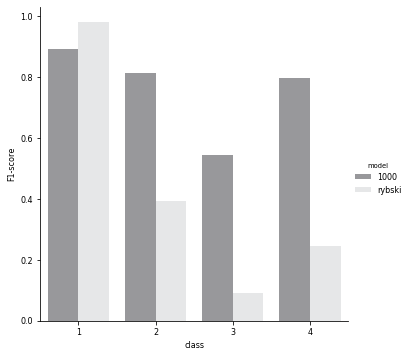

In [41]:
flatui = [np.array([151, 152, 155])/255., np.array([230,231,232])/255.]
palette = sns.color_palette(flatui)

g = sns.catplot(x="class", y='f1', hue="model", data=df[df.model.isin({'1000', 'rybski'})],
                height=5, kind="bar", palette=palette)
plt.ylabel("F1-score")

plt.savefig('../figures/manuscript/boxplot_classes.pdf', dpi=150, bbox_inches='tight', pad_inches=0.05)

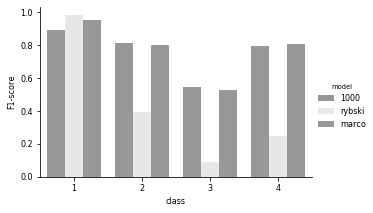

In [42]:
g = sns.catplot(x="class", y='f1', hue="model", data=df,
                height=3, kind="bar", palette=palette, aspect=1.5)
plt.ylabel("F1-score")

plt.savefig('../figures/manuscript/multi_boxplot_classes.pdf', dpi=150, bbox_inches='tight', pad_inches=0.05)